In [ ]:
# ..... clustering with Monocle3? ..... #

In [2]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(monocle3)
library(mclust)

In [3]:
# assign majority cell type label to cluster
get_cluster_label <- function(vec1, ctype1){
    cluster_list = unique(vec1)
    cluster_label = ctype1
    
    for(ii in 1:length(cluster_list)){
        ids = which(vec1==cluster_list[ii])
        cluster_label[ids] = names(which.max(table(ctype1[ids])))
    }
    
    return(cluster_label)
}

In [4]:
# load data
get_seurat_obj <- function(currstage1){
    
    sc1 = readRDS(paste0(currstage1, '_integrated_cca.rds'))

#     df1 = read.delim(paste0(currstage1, '_cluster_anno_Knight-Schrijver.csv'), sep = ',')
    df1 = read.delim(paste0(currstage1, '_Qiu_SHC_Monocle_clusters.csv'), sep = ',')
    
    ids = match(rownames(sc1@meta.data), df1$barcode)
    
#     sc1$metacell = df1$metacell[ids]
#     sc1$celltype = df1$consensus_type[ids]
#     sc1$cluster = df1$cluster[ids]
    
    sc1$celltype = df1$monocle_cluster[ids]
    sc1$celltype <- paste0(sc1$sample, '|', sc1$celltype)
    sc1$class = df1$class[ids]
    sc1$subclass = df1$celltype[ids]
    sc1$subclass2 = df1$final_celltype[ids]
    sc1$monocle_label = df1$monocle_label[ids]
    
    df2 = read.delim(paste0(currstage1, '_monocle_matched_clusters.csv'), sep = ',')
    sc1$cluster = df2$cluster[match(sc1$celltype, df2$metacell)]

    sc1$stage <- sc1$orig.ident
    sc1 <- sc1[,!is.na(sc1$celltype)]
    return(sc1)
}

In [19]:
# load individual sample files
stage1 = 'stage14'
sc1 = get_seurat_obj(stage1)

In [20]:
# get expr data for monocle
expression_matrix = sc1@assays$RNA@counts
gene_df = data.frame(gene_short_name = rownames(expression_matrix))
rownames(gene_df) = rownames(expression_matrix)

cds <- new_cell_data_set(expression_matrix,
                         cell_metadata = sc1@meta.data,
                         gene_metadata = gene_df)

## Step 1: Normalize and pre-process the data
cds <- preprocess_cds(cds, num_dim = 100)

## Step 3: Reduce the dimensions using UMAP
cds <- reduce_dimension(cds)

No preprocess_method specified, using preprocess_method = 'PCA'



No trajectory to plot. Has learn_graph() been called yet?



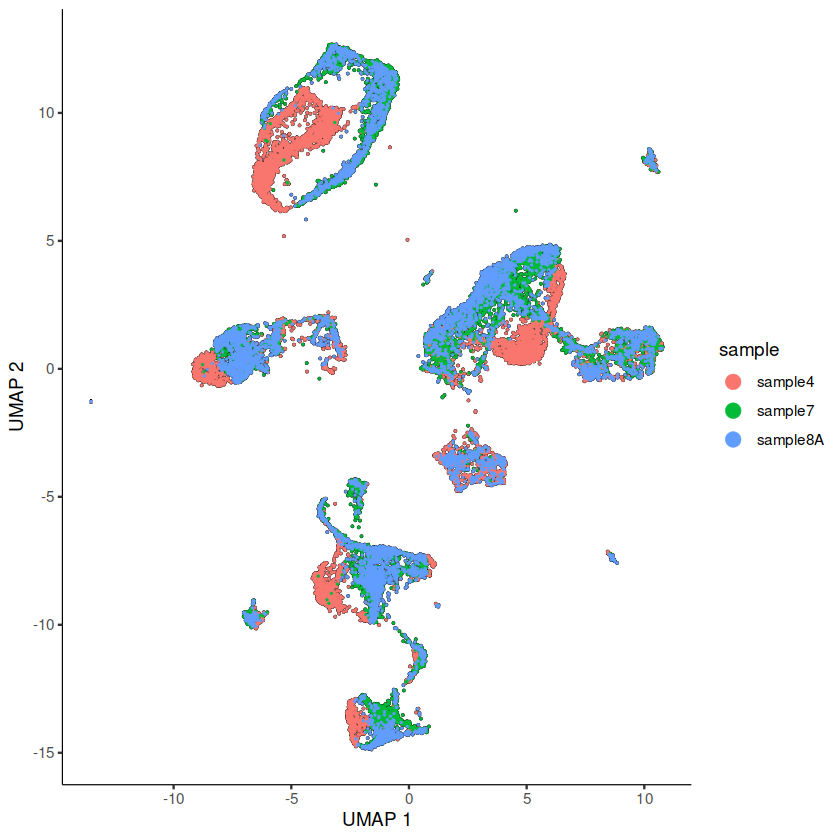

In [21]:
plot_cells(cds, color_cells_by = "sample", label_cell_groups = FALSE)

Aligning cells from different batches using Batchelor.
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091

No preprocess_method specified, and aligned coordinates have been computed previously. Using preprocess_method = 'Aligned'

No trajectory to plot. Has learn_graph() been called yet?



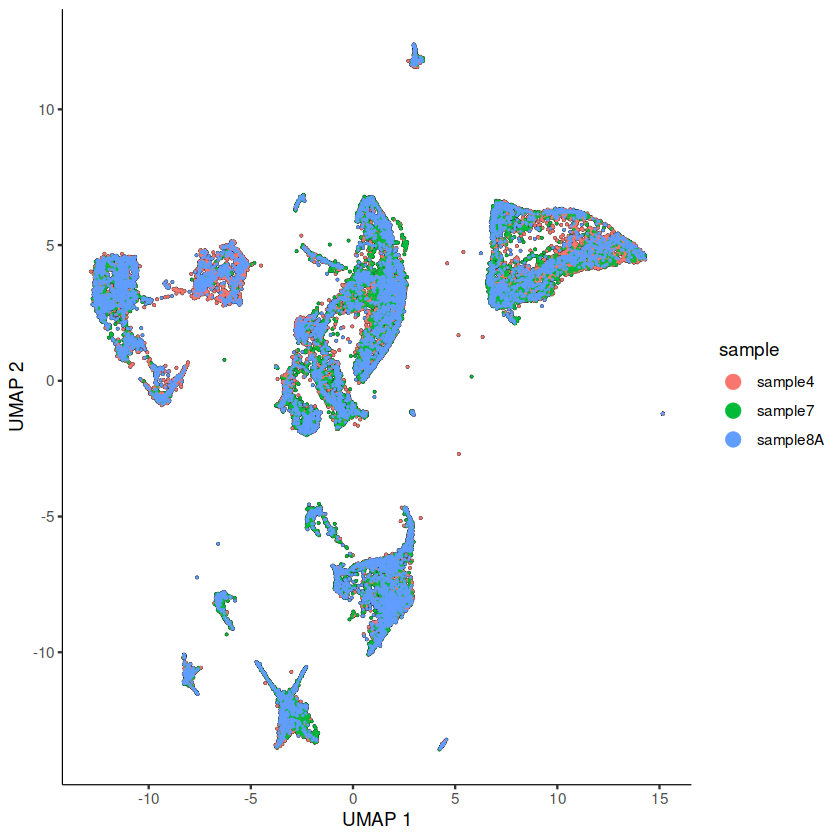

In [22]:
# removing batch effects
cds <- align_cds(cds, num_dim = 100, alignment_group = "sample")
cds <- reduce_dimension(cds)
plot_cells(cds, color_cells_by = "sample", label_cell_groups = FALSE)

In [23]:
cds <- reduce_dimension(cds, reduction_method = "tSNE")

No preprocess_method specified, and aligned coordinates have been computed previously. Using preprocess_method = 'Aligned'



No trajectory to plot. Has learn_graph() been called yet?



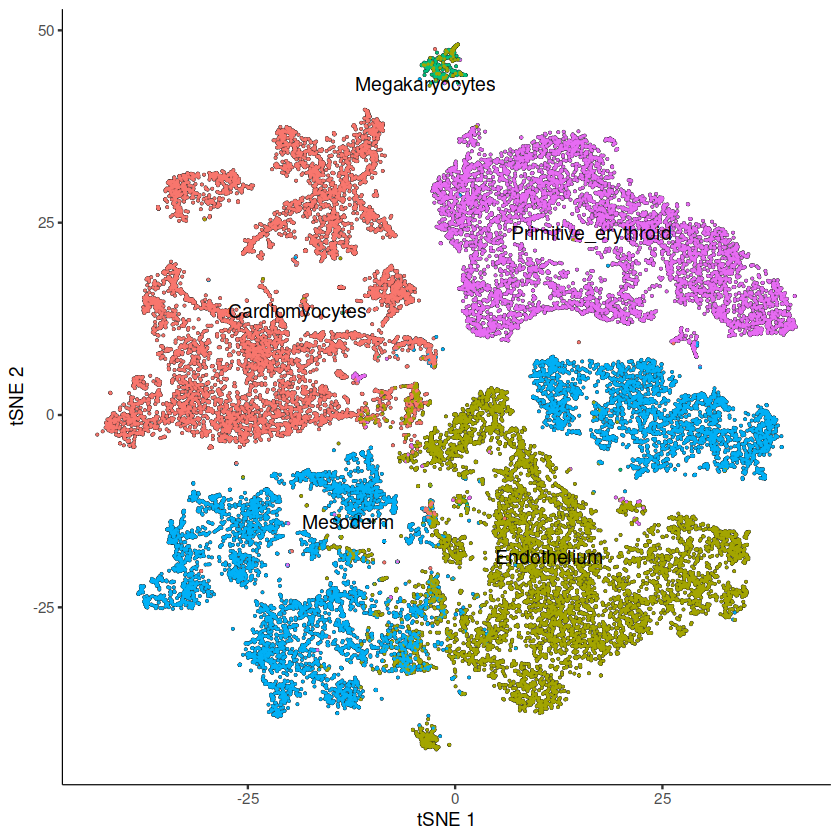

In [26]:
# png(paste0('aaa-turtle-', stage1, '-class-tsne.png'), width = 8, height = 8, units = 'in', res = 300)
plot_cells(cds, reduction_method = "tSNE", color_cells_by = "monocle_label", group_label_size = 4)
# dev.off()
# plot_cells(cds, color_cells_by="subclass2")

No trajectory to plot. Has learn_graph() been called yet?

Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


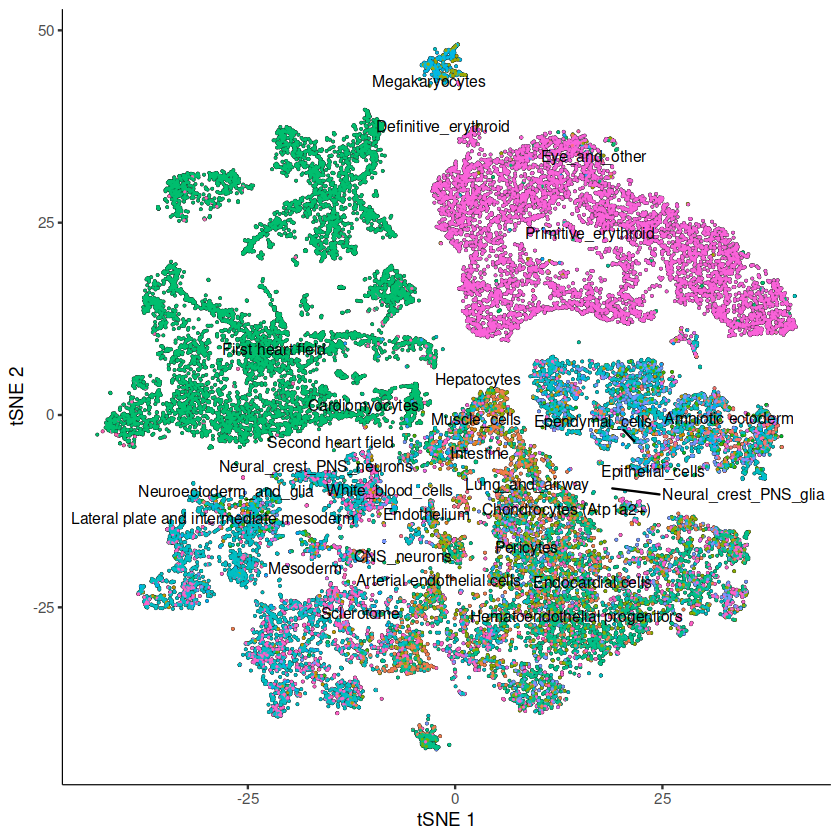

In [27]:
# png(paste0('aaa-turtle-', stage1, '-subclass-tsne.png'), width = 8, height = 8, units = 'in', res = 300)
plot_cells(cds, reduction_method = "tSNE", color_cells_by = "subclass2", group_label_size = 3.2)
# dev.off()

In [ ]:
# find top markers for each cell cluster
# assigned_type_marker_test_res <- top_markers(cds,
#                                              group_cells_by="cluster",
#                                              reference_cells=1000,
#                                              cores=8)

In [ ]:
cds_subset <- cds[,cds$cluster=='cluster_4']
cds_subset <- cluster_cells(cds_subset, resolution=1e-3)
plot_cells(cds_subset, color_cells_by="cluster")

In [58]:
table(cds_subset$class[cds_subset@clusters@listData$UMAP$clusters==5])
table(cds_subset$subclass[cds_subset@clusters@listData$UMAP$clusters==5])


       Cardiomyocytes           Endothelium              Mesoderm 
                    5                   151                   138 
Neural_crest_PNS_glia   Primitive_erythroid 
                   37                     4 


             Arterial endothelial cells                            Dermomyotome 
                                     14                                       1 
                      Endocardial cells                       First heart field 
                                     53                                       5 
          Hematoendothelial progenitors Lateral plate and intermediate mesoderm 
                                     82                                      54 
                             Sclerotome 
                                     81 